In [1]:
# import libraries
import pandas as pd
import numpy as np
import sqlite3

import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to /Users/vikram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vikram/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vikram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Extracting 'elog_all_data' table from 'elog_data.db' database
conn = sqlite3.connect(r'/Users/vikram/Projects/Elog/data/elog_data.db')
c = conn.cursor()
c.execute('SELECT * FROM elog_all_data')
df = pd.DataFrame(c.fetchall(), columns=['elogid', 'tag', 'text', 'title', 'title_and_text'])
df.shape

(251193, 5)

> We want to implement a form of unsupervised learning that can <i>ideally</i> cluster these entries into 2 groups (LCLS and FACET). This will allow us to train our data on a much larger sample size across a much bigger time period, which will hopefully make our model more robust

### Tokenize Function

In [3]:
# Creat tokenizer function
def tokenize(x):
    
    # Generating list of stop words
    stop_words = set(stopwords.words('english'))
    
    # Separate sentance into individual words
    no_punctuation_x = re.sub(r"[^a-zA-Z0-9]"," ", x)
    word_token = word_tokenize(no_punctuation_x)
    
    # Lemmatizing each word and added cleaned words to clean_words
    lemmatizer = WordNetLemmatizer()
    clean_words = []
    for word in word_token:
        clean_words.append(lemmatizer.lemmatize(word.lower().strip()))

    # Return lematized words that are indeed words and are not in stopwords list
    final_token = [w for w in clean_words if w not in stop_words]
    return final_token

### LSA Method

Let's practice on a smaller subset of the data fram at first (let's say 100 random entries) and only test it on the title. We can then move onto incorporating the text after we get a working model

In [4]:
# practice with first 100 entries.
df_abbr = df.sample(n = 100)
df_abbr.head()

,elogid,tag,text,title,title_and_text
248309,966617,LCLS,They are going to test gas jet monitor with be...,"XLEAPers taking a break, putting in slotted fo...","XLEAPers taking a break, putting in slotted fo..."
81831,426426,None,"Reset locally, then IPL brought it back.",MC00 offline.,"MC00 offline. Reset locally, then IPL brought ..."
226727,904412,LCLS,This is behind the S6 stopper but evidently th...,* Re: MPS fault for MEC BXL VGC 01 Gate Valve ...,* Re: MPS fault for MEC BXL VGC 01 Gate Valve ...
238180,939703,LCLS,,27-4 to standby for PEM job.,27-4 to standby for PEM job.
126328,625259,LCLS,,James Bong will be here in 1 hour.,James Bong will be here in 1 hour.


In [20]:
# Creating a bag of words for our 100 log entry sample (takes about a couple minutes to run)
vectorizer = CountVectorizer(tokenizer = tokenize)       # Calls our tokenize function written above
bag_of_words = vectorizer.fit_transform(df.title)        # Fitting just the title column for now
bag_of_words.todense()                                   # Visual verification of bag of words matrix

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [21]:
# Applying SVD down to 2 components for our bag_of_words (bout a minute)
svd = TruncatedSVD(n_components = 2)
lsa = svd.fit_transform(bag_of_words)

In [24]:
topic_encoded_df = pd.DataFrame(lsa, columns = ['topic1', 'topic2'])
topic_encoded_df['body'] = df['title'].tolist()
topic_encoded_df.tail(100)

,topic1,topic2,body
251093,0.027989,0.754715,Delivering 3.4 mJ at 9 KeV to MEC
251094,0.005411,0.110048,"Switched to 9 KeV for MEC, now STDZing"
251095,0.005315,0.059559,XPP/XCS done!
251096,0.013279,0.032244,Lowered L1X amplitude to 20 MV
251097,0.001684,0.019817,* Re: A bunch of IOCs in Li28 have gone purple...
251098,0.007749,0.122769,MEC will want to start at 9 keV
251099,0.001375,0.015716,Bryce pulsing LTU gas jet.
251100,0.001279,0.013293,A bunch of IOCs in Li28 have gone purple
251101,2.534370,-0.127633,"MCC Shift Change: Swing Shift, Monday, 03-Dec-..."
251102,1.103970,-0.066332,DAY SHIFT SUMMARY


* Let's try and get a plot of the data to kind of see what it looks like by plotting topic 1 vs top 2, and coloring the points depending on their tag

In [45]:
# Adding tags to dataframe. KEEP IN MIND THESE ARE NOT ALL ACCURATE
topic_encoded_df['tag'] = df['tag'].tolist()
topic_encoded_df.loc[(topic_encoded_df['tag'].isnull() == True), 'tag'] = 'None'
topic_encoded_df.tag.value_counts()

None     126947
LCLS      96056
FACET     28190
Name: tag, dtype: int64

Text(0.5, 1.0, 'Separating the Data by Topic')

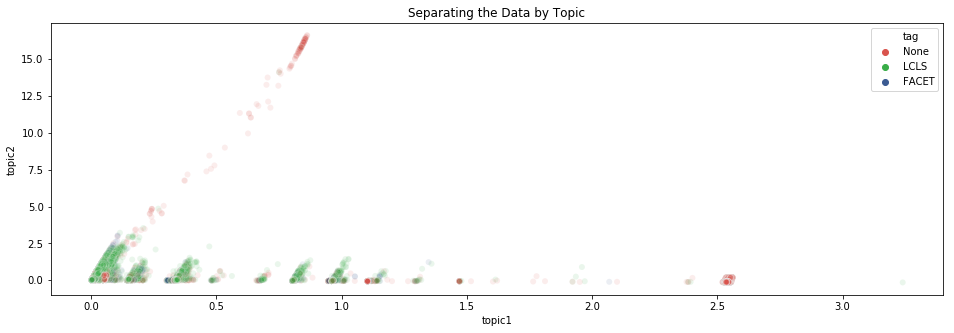

In [60]:
# Plotting data
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Takes about a minute to Plot
plt.figure(figsize = (16,5))
colors = [sb.xkcd_rgb["pale red"],sb.xkcd_rgb["medium green"],sb.xkcd_rgb["denim blue"]]
sb.scatterplot(data = topic_encoded_df, x = 'topic1', y = 'topic2', hue = 'tag', palette = colors, alpha = .1)
plt.title('Separating the Data by Topic')

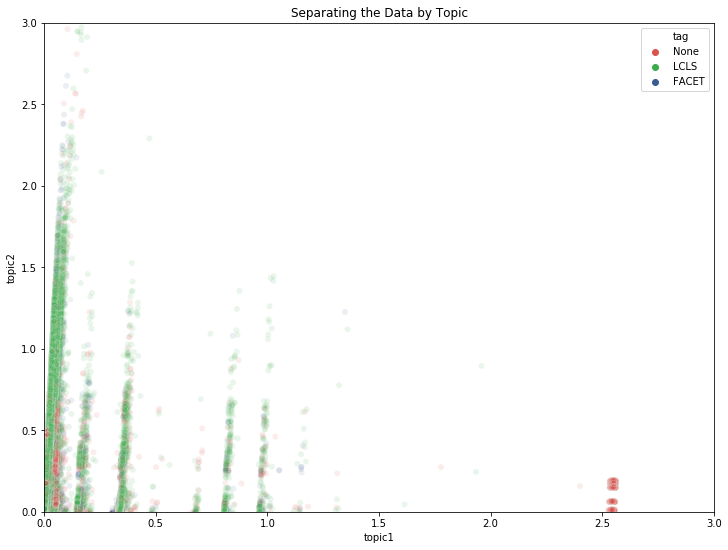

In [63]:
# Axis are not scaled in above image, and many points lie tight in bottom corner. Let's blow up that corner
plt.figure(figsize = (12,9))
colors = [sb.xkcd_rgb["pale red"],sb.xkcd_rgb["medium green"],sb.xkcd_rgb["denim blue"]]
g = sb.scatterplot(data = topic_encoded_df, x = 'topic1', y = 'topic2', hue = 'tag', palette = colors, alpha = .1)
g = (g.set(xlim=(0,3),ylim=(0,3)))
plt.title('Separating the Data by Topic')
plt.show(g)

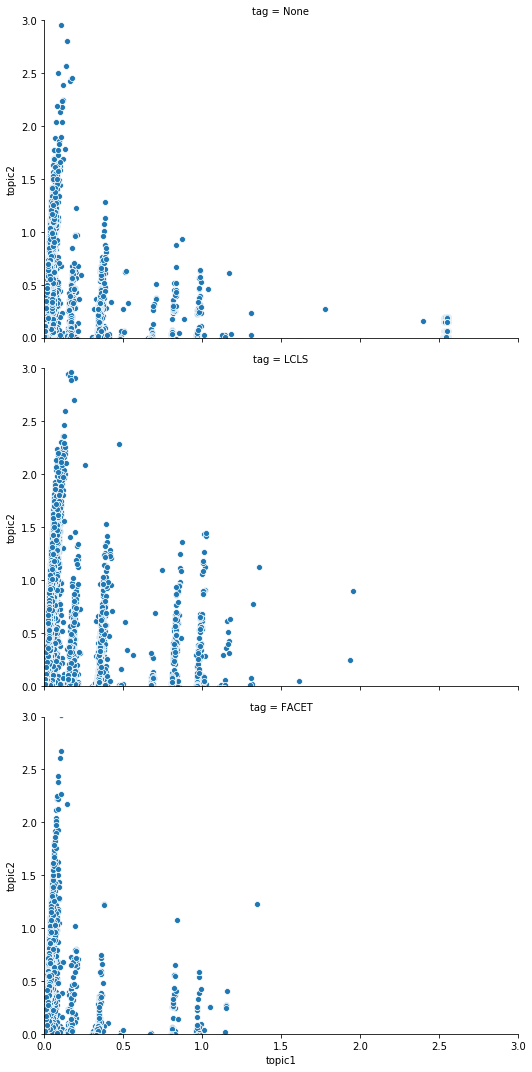

In [71]:
# Zoomed in view at each plot based on tag
g = sb.FacetGrid(topic_encoded_df, row='tag', height=5, ylim=(0, 3), xlim=(0, 3), aspect = 1.5);
g.map(sb.scatterplot, 'topic1', 'topic2');

### Obviously, looking at the plots above, we can see that the algorithm isn't working perfectly. LCLS and FACET entries are still highlighy correlated. However:

* Plot tags are <b> not always right </b>. So take these classifications with a grain of salt.
* Right now all entries are weighted equally. Implement TFIDF
* Explore other unsupervised methods
